In [17]:
# Force reload of modules during development
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from dotenv import load_dotenv

import sys
sys.path.append(str(Path.cwd().parent))

from ingestion.database import get_connection
from features.database import get_raw_series, get_features, upsert_features
from features.compute import compute_all_features
from features.basic import compute_all_basic_features
from features.cleaning import validate_data_quality
from features.diagnostics import (
    categorize_feature_frequency,
    check_forward_fill_behavior,
    find_missing_dates,
    analyze_feature_completeness,
    get_feature_start_dates,
    get_core_features
)

In [19]:
# Load environment and connect to database
load_dotenv()
db_password = os.getenv('DB_PASSWORD')

conn = get_connection(password=db_password)
print("Connected to database")

Connected to database


In [20]:
# Inspect raw data
df_raw = get_raw_series(conn, ticker='^GSPC', start_date='2010-01-01')
print(f"Loaded {len(df_raw)} rows for GSPC")
print(f"\nDate range: {df_raw['dt'].min()} to {df_raw['dt'].max()}")
df_raw.head(10)

Loaded 4012 rows for GSPC

Date range: 2010-01-04 to 2025-12-12


,ticker,asset_class,dt,value,source
0,^GSPC,EQUITY,2010-01-04,1132.989990,yfinance
1,^GSPC,EQUITY,2010-01-05,1136.520020,yfinance
2,^GSPC,EQUITY,2010-01-06,1137.140015,yfinance
3,^GSPC,EQUITY,2010-01-07,1141.689941,yfinance
4,^GSPC,EQUITY,2010-01-08,1144.979980,yfinance
5,^GSPC,EQUITY,2010-01-11,1146.979980,yfinance
6,^GSPC,EQUITY,2010-01-12,1136.219971,yfinance
7,^GSPC,EQUITY,2010-01-13,1145.680054,yfinance
8,^GSPC,EQUITY,2010-01-14,1148.459961,yfinance
9,^GSPC,EQUITY,2010-01-15,1136.030029,yfinance


In [21]:
# Test basic feature computation for a single ticker
df_test = df_raw[['dt', 'value']].copy()
df_test = df_test.set_index('dt')

features = compute_all_basic_features(df_test, '^GSPC', 'EQUITY').set_index('dt')
print(f"Computed {len(features)} features")
print(f"Unique features: {features['feature'].unique()}")
features.head(10)

Computed 35902 features
Unique features: ['^GSPC_LEVEL' '^GSPC_RET_1D' '^GSPC_RET_5D' '^GSPC_RET_20D'
 '^GSPC_RET_60D' '^GSPC_MOM_20D' '^GSPC_MOM_60D' '^GSPC_VOL_20D'
 '^GSPC_VOL_60D']


,ticker,asset_class,feature,value
dt,,,,
2010-01-04,^GSPC,EQUITY,^GSPC_LEVEL,1132.989990
2010-01-05,^GSPC,EQUITY,^GSPC_LEVEL,1136.520020
2010-01-06,^GSPC,EQUITY,^GSPC_LEVEL,1137.140015
2010-01-07,^GSPC,EQUITY,^GSPC_LEVEL,1141.689941
2010-01-08,^GSPC,EQUITY,^GSPC_LEVEL,1144.979980
2010-01-11,^GSPC,EQUITY,^GSPC_LEVEL,1146.979980
2010-01-12,^GSPC,EQUITY,^GSPC_LEVEL,1136.219971
2010-01-13,^GSPC,EQUITY,^GSPC_LEVEL,1145.680054
2010-01-14,^GSPC,EQUITY,^GSPC_LEVEL,1148.459961


In [22]:
features[features['feature'] == '^GSPC_RET_20D']['value']

dt
2010-02-02   -0.026187
2010-02-03   -0.034526
2010-02-04   -0.065102
2010-02-05   -0.066130
2010-02-08   -0.077067
                ...   
2025-12-08    0.017493
2025-12-09    0.001183
2025-12-10    0.005853
2025-12-11    0.007310
2025-12-12    0.013346
Name: value, Length: 3992, dtype: float64

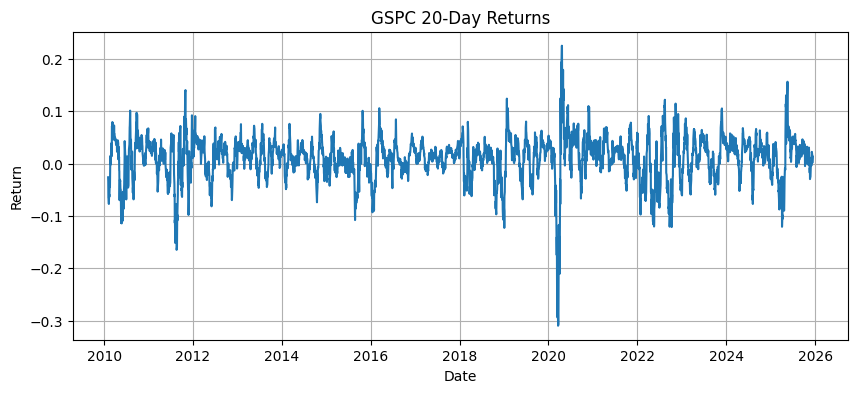

In [23]:
# Visualize feature distributions
import matplotlib.pyplot as plt

if '^GSPC_RET_20D' in features['feature'].values:
    ret_20d = features[features['feature'] == '^GSPC_RET_20D']['value']
    plt.figure(figsize=(10, 4))
    plt.plot(ret_20d.index, ret_20d.values)  # type: ignore
    plt.title('GSPC 20-Day Returns')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True)
    plt.show()

In [24]:
# Run full feature computation pipeline
# This computes all features for all tickers and stores them in the database

result = compute_all_features(
    conn,
    version='V2_FWD_FILL',
    start_date='2010-01-01',
    ticker_filter=None,  # None = all tickers
    forward_fill=True,
    business_days_only=True
)

print("\nFeature computation summary:")
print(result)

Starting feature computation (version: V2_FWD_FILL)...
Loading raw data...
Loaded 54 tickers
Cleaning and preparing data...
Computing basic features...
  Computed 1357932 basic features
Computing spread features...
  Computed 52350 spread features
Computing ratio features...
  Computed 46583 ratio features
Computing global aggregates...
  Computed 38439 aggregate features
Combining all features...
Total features computed: 1,495,304
Unique features: 376
Date range: 2010-01-01 to 2025-12-14
Smart forward-filling features based on natural frequency...
  Before: 1,495,304 rows
  Business days in range: 4161 days
  Processed 50/376 features
  Processed 100/376 features
  Processed 150/376 features
  Processed 200/376 features
  Processed 250/376 features
  Processed 300/376 features
  Processed 350/376 features
  Processed 376/376 features

  Frequency distribution:
    DAILY: 360 features
    WEEKLY: 8 features
    MONTHLY: 7 features
    QUARTERLY: 1 features

  After: 1,534,055 rows
  Ad

In [46]:
# Inspect computed features
df_features = get_features(conn, version='V2_FWD_FILL', start_date='2010-01-01')
print(f"Loaded {len(df_features)} feature rows")
print(f"Unique features: {df_features['feature'].nunique()}")
print(f"\nFeature types:")
df_features['feature'].value_counts().sort_values(ascending=True)

Loaded 1534055 feature rows
Unique features: 376

Feature types:


feature
SOFR_CHG_60D       1949
SOFR_CHG_20D       1989
SOFR_CHG_1D        2008
SOFR_LEVEL         2009
BTC-USD_MOM_60D    2890
                   ... 
GBPUSD=X_LEVEL     4161
FEDFUNDS_LEVEL     4161
FX_AUD_JPY         4161
NFCI_LEVEL         4161
AUDUSD=X_LEVEL     4161
Name: count, Length: 376, dtype: int64

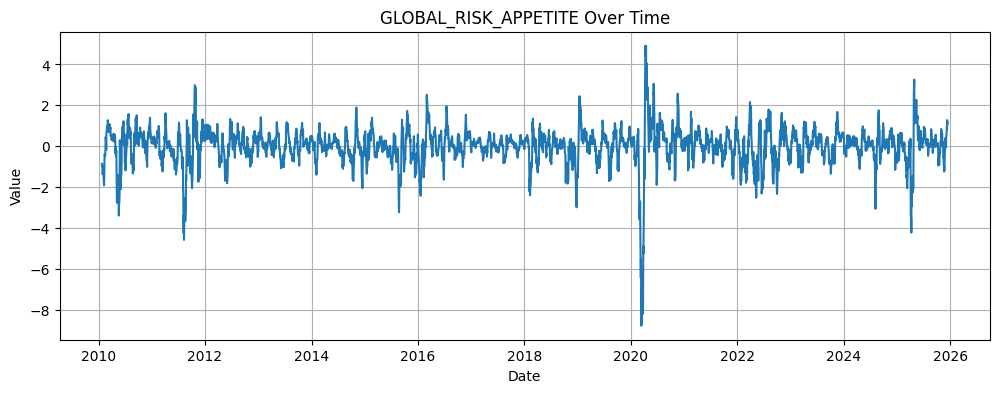


Statistics for GLOBAL_RISK_APPETITE:
count    4145.000000
mean       -0.004732
std         0.908425
min        -8.782673
25%        -0.352049
50%         0.091900
75%         0.454842
max         4.916621
Name: value, dtype: float64


In [48]:
# Example: View specific feature over time
feature_name = 'GLOBAL_RISK_APPETITE'  # Change to any feature name
df_feature = df_features[df_features['feature'] == feature_name].sort_values('dt')  # type: ignore

if not df_feature.empty:
    plt.figure(figsize=(12, 4))
    plt.plot(pd.to_datetime(df_feature['dt']), df_feature['value'])
    plt.title(f'{feature_name} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()
    
    print(f"\nStatistics for {feature_name}:")
    print(df_feature['value'].describe())
else:
    print(f"Feature {feature_name} not found")

In [27]:
# View global aggregate features
global_features = df_features[df_features['ticker'] == 'GLOBAL']
print(f"Global features: {global_features['feature'].unique()}") # type: ignore
print(f"\nSample global features:")
global_features.head(10)

Global features: ['FX_AUD_JPY' 'GLOBAL_FINANCIAL_CONDITIONS' 'COMMODITY_GOLD_OIL'
 'CREDIT_HY_SPREAD' 'CREDIT_IG_SPREAD' 'EQUITY_EM_VS_US'
 'GLOBAL_INFLATION_EXPECTATIONS' 'GLOBAL_YIELD_CURVE_SLOPE'
 'REAL_RATE_10Y' 'STYLE_CYCLICAL_VS_DEFENSIVE' 'STYLE_GROWTH_VS_VALUE'
 'STYLE_SMALL_VS_LARGE' 'VOL_VIX_LEVEL' 'VOL_VVIX_VIX' 'YCURVE_2S10S'
 'YCURVE_2S5S' 'YCURVE_5S30S' 'GLOBAL_INFLATION_REALIZED'
 'GLOBAL_GROWTH_SIGNAL' 'CREDIT_HY_CHG_20D' 'CREDIT_IG_CHG_20D'
 'GLOBAL_EQUITY_MOMENTUM' 'GLOBAL_RISK_APPETITE']

Sample global features:


,dt,ticker,asset_class,feature,value,version
6,2010-01-01,GLOBAL,MACRO,FX_AUD_JPY,0.009669,V2_FWD_FILL
7,2010-01-01,GLOBAL,MACRO,GLOBAL_FINANCIAL_CONDITIONS,-0.178560,V2_FWD_FILL
39,2010-01-04,GLOBAL,MACRO,COMMODITY_GOLD_OIL,13.712427,V2_FWD_FILL
40,2010-01-04,GLOBAL,MACRO,CREDIT_HY_SPREAD,6.340000,V2_FWD_FILL
41,2010-01-04,GLOBAL,MACRO,CREDIT_IG_SPREAD,1.880000,V2_FWD_FILL
42,2010-01-04,GLOBAL,MACRO,EQUITY_EM_VS_US,0.027172,V2_FWD_FILL
43,2010-01-04,GLOBAL,MACRO,FX_AUD_JPY,0.009865,V2_FWD_FILL
44,2010-01-04,GLOBAL,MACRO,GLOBAL_FINANCIAL_CONDITIONS,-0.178560,V2_FWD_FILL
45,2010-01-04,GLOBAL,MACRO,GLOBAL_INFLATION_EXPECTATIONS,2.255000,V2_FWD_FILL
46,2010-01-04,GLOBAL,MACRO,GLOBAL_YIELD_CURVE_SLOPE,2.760000,V2_FWD_FILL


In [40]:
# Reconnect to database if needed
try:
    # Test if connection is still alive
    cursor = conn.cursor()
    cursor.execute("SELECT 1")
    cursor.close()
    print("✅ Database connection is active")
except:
    print("⚠️  Connection closed, reconnecting...")
    conn = get_connection(password=db_password)
    print("✅ Reconnected to database")

⚠️  Connection closed, reconnecting...
✅ Reconnected to database


# Data Quality Diagnostics

This section validates the V2_FWD_FILL dataset using all available diagnostic functions.

**What we're checking:**
1. Feature frequency distribution (should all be DAILY after forward-fill)
2. Weekend data presence (should be none with business_days_only=True)
3. Feature completeness (should be 100% for all features)
4. Feature start dates (to understand data availability)
5. Core features for ML (features with longest history)

In [63]:
# 1. Feature Frequency Analysis
# After forward-fill, all features should be DAILY with ~261 obs/year

df_freq = categorize_feature_frequency(conn, version='V2_FWD_FILL')

# Check results
print("\n" + "="*80)
print("VALIDATION RESULTS")
print("="*80)

all_daily = (df_freq['frequency'] == 'DAILY').all()
avg_obs = df_freq['obs_per_year'].mean()

if all_daily:
    print("✅ ALL features are DAILY frequency (forward-fill working)")
else:
    print("⚠️  Some features are not daily!")
    non_daily = df_freq[df_freq['frequency'] != 'DAILY']
    print(f"\nNon-daily features: {len(non_daily)}")
    print(non_daily[['feature', 'frequency', 'obs_per_year']])

if 260 <= avg_obs <= 262:
    print(f"✅ Average {avg_obs:.1f} obs/year (expected ~261 trading days)")
else:
    print(f"⚠️  Average {avg_obs:.1f} obs/year (expected ~261)")

# Show feature summary
print(f"\n📊 Feature Summary:")
print(f"   Total features: {len(df_freq)}")
print(f"   Date range: {df_freq['first_date'].min()} to {df_freq['last_date'].max()}")
print(f"   Observations per year: {df_freq['obs_per_year'].describe()[['min', 'mean', 'max']]}")

df_freq.head(10)


/Users/alecmitchell-thomson/Desktop/Coding/macro-regime-engine/src/features/diagnostics.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=[version])


FEATURE FREQUENCY ANALYSIS

Total features: 376

Frequency distribution:
frequency
DAILY    376
Name: count, dtype: int64

Observations per year by frequency:
           count       mean       std    min    25%    50%    75%    max
frequency                                                               
DAILY      376.0  261.00266  0.016111  261.0  261.0  261.0  261.0  261.1

VALIDATION RESULTS
✅ ALL features are DAILY frequency (forward-fill working)
✅ Average 261.0 obs/year (expected ~261 trading days)

📊 Feature Summary:
   Total features: 376
   Date range: 2010-01-01 to 2025-12-12
   Observations per year: min     261.00000
mean    261.00266
max     261.10000
Name: obs_per_year, dtype: float64


,feature,ticker,asset_class,frequency,median_gap_days,observations,obs_per_year,expected_behavior,first_date,last_date
0,000001.SS_LEVEL,000001.SS,EQUITY,DAILY,1,4160,261.0,Should be nearly complete,2010-01-04,2025-12-12
1,000001.SS_MOM_20D,000001.SS,EQUITY,DAILY,1,4140,261.0,Should be nearly complete,2010-02-01,2025-12-12
2,000001.SS_MOM_60D,000001.SS,EQUITY,DAILY,1,4094,261.0,Should be nearly complete,2010-04-06,2025-12-12
3,000001.SS_RET_1D,000001.SS,EQUITY,DAILY,1,4159,261.0,Should be nearly complete,2010-01-05,2025-12-12
4,000001.SS_RET_20D,000001.SS,EQUITY,DAILY,1,4140,261.0,Should be nearly complete,2010-02-01,2025-12-12
5,000001.SS_RET_5D,000001.SS,EQUITY,DAILY,1,4155,261.0,Should be nearly complete,2010-01-11,2025-12-12
6,000001.SS_RET_60D,000001.SS,EQUITY,DAILY,1,4094,261.0,Should be nearly complete,2010-04-06,2025-12-12
7,000001.SS_VOL_20D,000001.SS,EQUITY,DAILY,1,4150,261.0,Should be nearly complete,2010-01-18,2025-12-12
8,000001.SS_VOL_60D,000001.SS,EQUITY,DAILY,1,4125,261.0,Should be nearly complete,2010-02-22,2025-12-12
9,AUDUSD=X_LEVEL,AUDUSD=X,FX,DAILY,1,4161,261.0,Should be nearly complete,2010-01-01,2025-12-12


In [64]:
# 2. Weekend/Holiday Data Check
# Should have NO weekend dates with business_days_only=True

date_analysis = check_forward_fill_behavior(conn, version='V2_FWD_FILL')

# Validate results
has_weekends = date_analysis['is_weekend'].sum() > 0

if not has_weekends:
    print("\n✅ VALIDATION PASSED: No weekend data found")
else:
    print("\n❌ VALIDATION FAILED: Weekend data detected")
    print("   This indicates forward-fill did not use business_days_only")
    
# Check day distribution is balanced (roughly equal Mon-Fri)
day_counts = date_analysis.groupby('day_of_week').size()
if len(day_counts) == 5:  # Only weekdays
    variance = day_counts.std()
    if variance < 5:  # Low variance = balanced
        print("✅ Day-of-week distribution is balanced")
    else:
        print(f"⚠️  Day-of-week variance is {variance:.1f} (check for missing days)")

date_analysis.tail()


/Users/alecmitchell-thomson/Desktop/Coding/macro-regime-engine/src/features/diagnostics.py:122: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=[version])


FORWARD-FILL BEHAVIOR CHECK

Total dates in database: 4,161
Weekend dates: 0

Day of week distribution:
  Monday: 832
  Tuesday: 832
  Wednesday: 832
  Thursday: 832
  Friday: 833
  Saturday: 0
  Sunday: 0

✅ No weekend data found - forward-fill is working correctly!

✅ VALIDATION PASSED: No weekend data found
✅ Day-of-week distribution is balanced


,dt,num_features,day_of_week,is_weekend
4156,2025-12-08,376,0,False
4157,2025-12-09,376,1,False
4158,2025-12-10,376,2,False
4159,2025-12-11,376,3,False
4160,2025-12-12,376,4,False


In [65]:
# 3. Comprehensive Completeness Analysis
# Should show 100% completeness for all features

df_completeness = analyze_feature_completeness(conn, version='V2_FWD_FILL')

# Validate results
print("\n" + "="*80)
print("COMPLETENESS VALIDATION")
print("="*80)

all_complete = (df_completeness['pct_complete'] == 100.0).all()
avg_complete = df_completeness['pct_complete'].mean()
incomplete_count = (df_completeness['pct_complete'] < 100).sum()

if all_complete:
    print("✅ ALL features are 100% complete!")
    print(f"   Total features: {len(df_completeness)}")
    print(f"   Total rows: {df_completeness['actual_rows'].sum():,}")
    print(f"   No missing data detected")
else:
    print(f"⚠️  {incomplete_count} features are not complete")
    print(f"   Average completeness: {avg_complete:.1f}%")
    incomplete = df_completeness[df_completeness['pct_complete'] < 100]
    print(f"\n   Incomplete features:")
    print(incomplete[['feature', 'pct_complete', 'missing_days']].head(10)) #type: ignore

df_completeness.head(10)


/Users/alecmitchell-thomson/Desktop/Coding/macro-regime-engine/src/features/diagnostics.py:230: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=[version])


Loaded 1,534,055 feature rows
Date range: 2010-01-01 to 2025-12-12
Unique features: 376

FEATURE COMPLETENESS ANALYSIS

Total features: 376

Start date distribution:
first_date
2010-01-04    57
2010-02-02    40
2010-03-31    38
2010-01-05    38
2010-02-01    29
2010-01-11    23
2010-01-19    20
2010-02-17    20
2010-03-29    18
2010-01-01    15
Name: count, dtype: int64

Completeness summary:
count    376.0
mean     100.0
std        0.0
min      100.0
25%      100.0
50%      100.0
75%      100.0
max      100.0
Name: pct_complete, dtype: float64

FEATURES WITH MISSING DATA (< 95% complete)
✅ No features with significant missing data!

FEATURES WITH LARGE GAPS (> 7 days)
✅ No features with large gaps!

COMPLETENESS VALIDATION
✅ ALL features are 100% complete!
   Total features: 376
   Total rows: 1,534,055
   No missing data detected


,feature,ticker,asset_class,first_date,last_date,actual_rows,expected_bdays,pct_complete,missing_days,max_gap_days,large_gaps
0,000001.SS_LEVEL,000001.SS,EQUITY,2010-01-04,2025-12-12,4160,4160,100.0,0,3,0
1,000001.SS_MOM_20D,000001.SS,EQUITY,2010-02-01,2025-12-12,4140,4140,100.0,0,3,0
2,000001.SS_MOM_60D,000001.SS,EQUITY,2010-04-06,2025-12-12,4094,4094,100.0,0,3,0
3,000001.SS_RET_1D,000001.SS,EQUITY,2010-01-05,2025-12-12,4159,4159,100.0,0,3,0
4,000001.SS_RET_20D,000001.SS,EQUITY,2010-02-01,2025-12-12,4140,4140,100.0,0,3,0
5,000001.SS_RET_5D,000001.SS,EQUITY,2010-01-11,2025-12-12,4155,4155,100.0,0,3,0
6,000001.SS_RET_60D,000001.SS,EQUITY,2010-04-06,2025-12-12,4094,4094,100.0,0,3,0
7,000001.SS_VOL_20D,000001.SS,EQUITY,2010-01-18,2025-12-12,4150,4150,100.0,0,3,0
8,000001.SS_VOL_60D,000001.SS,EQUITY,2010-02-22,2025-12-12,4125,4125,100.0,0,3,0
9,AUDUSD=X_LEVEL,AUDUSD=X,FX,2010-01-01,2025-12-12,4161,4161,100.0,0,3,0


In [66]:
# 4. Feature Start Date Analysis
# Understand when each feature becomes available

df_starts = get_feature_start_dates(conn, version='V2_FWD_FILL')

# Analyze start date distribution
print("\n" + "="*80)
print("START DATE INSIGHTS")
print("="*80)
 
earliest = df_starts['first_date'].min()
latest = df_starts['first_date'].max()
date_spread = (latest - earliest).days

print(f"Earliest feature start: {earliest.date()}")
print(f"Latest feature start: {latest.date()}")
print(f"Date spread: {date_spread} days ({date_spread/365.25:.1f} years)")

# Show start date clusters
print(f"\nTop 10 start dates (# of features):")
print(df_starts['first_date'].value_counts().head(10))

# Features availability over time
cutoff_dates = ['2010-01-05', '2011-01-01', '2014-01-01', '2018-01-01']
print(f"\nFeature availability timeline:")
for cutoff in cutoff_dates:
    count = (df_starts['first_date'] <= cutoff).sum()
    print(f"  By {cutoff}: {count:3d} features ({count/len(df_starts)*100:.1f}%)")

df_starts.head(15)


/Users/alecmitchell-thomson/Desktop/Coding/macro-regime-engine/src/features/diagnostics.py:336: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=[version])


FEATURE START DATES

Total features: 376

Earliest start: 2010-01-01
Latest start: 2018-06-26

Features starting by common dates:
  By 2010-01-04: 72 features
  By 2011-01-03: 361 features
  By 2014-01-02: 363 features
  By 2018-01-02: 372 features

Start date distribution:
first_date
2010-01-04    57
2010-02-02    40
2010-01-05    38
2010-03-31    38
2010-02-01    29
2010-01-11    23
2010-02-17    20
2010-01-19    20
2010-03-29    18
2010-01-01    15
2010-01-29     8
2011-01-03     8
2010-03-26     8
2010-01-08     5
2010-01-25     4
Name: count, dtype: int64

START DATE INSIGHTS
Earliest feature start: 2010-01-01
Latest feature start: 2018-06-26
Date spread: 3098 days (8.5 years)

Top 10 start dates (# of features):
first_date
2010-01-04    57
2010-02-02    40
2010-01-05    38
2010-03-31    38
2010-02-01    29
2010-01-11    23
2010-02-17    20
2010-01-19    20
2010-03-29    18
2010-01-01    15
Name: count, dtype: int64

Feature availability timeline:
  By 2010-01-05: 110 features (29

,feature,ticker,first_date,total_observations
0,AUDUSD=X_LEVEL,AUDUSD=X,2010-01-01,4161
1,CPIAUCSL_LEVEL,CPIAUCSL,2010-01-01,4161
2,EURUSD=X_LEVEL,EURUSD=X,2010-01-01,4161
3,FEDFUNDS_LEVEL,FEDFUNDS,2010-01-01,4161
4,FX_AUD_JPY,GLOBAL,2010-01-01,4161
5,GBPUSD=X_LEVEL,GBPUSD=X,2010-01-01,4161
6,GDP_LEVEL,GDP,2010-01-01,4161
7,GLOBAL_FINANCIAL_CONDITIONS,GLOBAL,2010-01-01,4161
8,M2SL_LEVEL,M2SL,2010-01-01,4161
9,NFCI_LEVEL,NFCI,2010-01-01,4161


In [68]:
# 5. Get Core Features for ML Dataset
# Features that started early = maximum historical data

# Get features that started by 2010-01-05 (most features start here)
core_features = get_core_features(conn, version='V2_FWD_FILL', cutoff_date='2011-01-01')

print(f"\n✅ Core Features Retrieved: {len(core_features)}")
print(f"   These features have data from 2010-01-04 onwards")
print(f"   Approximately 15+ years of history")

# Analyze what we're excluding
excluded_count = len(df_starts) - len(core_features)
if excluded_count > 0:
    excluded_features = df_starts[~df_starts['feature'].isin(core_features)]
    print(f"\n📊 Excluded {excluded_count} features that started after 2010-01-05:")
    print(f"   These are nice-to-have but not essential")
    
    # Show some examples
    late_starters = excluded_features.sort_values('first_date').head(5)  # type: ignore
    print(f"\n   Examples of excluded features:")
    for _, row in late_starters.iterrows():
        print(f"     {row['feature']}: started {row['first_date'].date()}")  # type: ignore


/Users/alecmitchell-thomson/Desktop/Coding/macro-regime-engine/src/features/diagnostics.py:336: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=[version])


FEATURE START DATES

Total features: 376

Earliest start: 2010-01-01
Latest start: 2018-06-26

Features starting by common dates:
  By 2010-01-04: 72 features
  By 2011-01-03: 361 features
  By 2014-01-02: 363 features
  By 2018-01-02: 372 features

Start date distribution:
first_date
2010-01-04    57
2010-02-02    40
2010-01-05    38
2010-03-31    38
2010-02-01    29
2010-01-11    23
2010-02-17    20
2010-01-19    20
2010-03-29    18
2010-01-01    15
2010-01-29     8
2011-01-03     8
2010-03-26     8
2010-01-08     5
2010-01-25     4
Name: count, dtype: int64

CORE FEATURES (started by 2011-01-01)
Core features: 353
Excluded features: 23

Excluded features (started after 2011-01-01):
  CPIAUCSL_CHG_YOY: started 2011-01-03
  FEDFUNDS_CHG_YOY: started 2011-01-03
  GDP_CHG_YOY: started 2011-01-03
  M2SL_CHG_YOY: started 2011-01-03
  PCEPI_CHG_YOY: started 2011-01-03
  UMCSENT_CHG_YOY: started 2011-01-03
  UNRATE_CHG_YOY: started 2011-01-03
  USSLIND_CHG_YOY: started 2011-01-03
  NFCI_CHG

In [69]:
# 6. Spot Check Individual Features
# Verify specific features for completeness

# Check a few representative features
test_features = [
    '^GSPC_LEVEL',      # Daily equity data
    'GDP_LEVEL',        # Quarterly macro (was sparse, now forward-filled)
    'UNRATE_LEVEL',     # Monthly macro (was sparse, now forward-filled)
    'DGS10_LEVEL'       # Daily rates data
]

print("=" * 80)
print("INDIVIDUAL FEATURE VALIDATION")
print("=" * 80)

all_passed = True
for feature in test_features:
    print(f"\n--- Checking {feature} ---")
    missing_df = find_missing_dates(conn, feature, version='V2_FWD_FILL')
    
    if missing_df is not None and len(missing_df) == 0:
        print("   ✅ PASSED: No missing dates")
    else:
        print(f"   ❌ FAILED: {len(missing_df) if missing_df is not None else 'Unknown'} missing dates")
        all_passed = False

print("\n" + "=" * 80)
if all_passed:
    print("✅ ALL SPOT CHECKS PASSED!")
else:
    print("⚠️  Some features have issues - review above")


INDIVIDUAL FEATURE VALIDATION

--- Checking ^GSPC_LEVEL ---
Feature: ^GSPC_LEVEL
Date range: 2010-01-04 to 2025-12-12
Expected business days: 4,160
Actual days: 4,160
Missing days: 0
Completeness: 100.0%

✅ No missing dates!
   ✅ PASSED: No missing dates

--- Checking GDP_LEVEL ---
Feature: GDP_LEVEL
Date range: 2010-01-01 to 2025-12-12
Expected business days: 4,161
Actual days: 4,161
Missing days: 0
Completeness: 100.0%

✅ No missing dates!
   ✅ PASSED: No missing dates

--- Checking UNRATE_LEVEL ---
Feature: UNRATE_LEVEL
Date range: 2010-01-01 to 2025-12-12
Expected business days: 4,161
Actual days: 4,161
Missing days: 0
Completeness: 100.0%

✅ No missing dates!
   ✅ PASSED: No missing dates

--- Checking DGS10_LEVEL ---
Feature: DGS10_LEVEL
Date range: 2010-01-04 to 2025-12-12
Expected business days: 4,160
Actual days: 4,160
Missing days: 0
Completeness: 100.0%

✅ No missing dates!
   ✅ PASSED: No missing dates

✅ ALL SPOT CHECKS PASSED!


/Users/alecmitchell-thomson/Desktop/Coding/macro-regime-engine/src/features/diagnostics.py:171: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=[feature_name, version])
/Users/alecmitchell-thomson/Desktop/Coding/macro-regime-engine/src/features/diagnostics.py:171: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=[feature_name, version])
/Users/alecmitchell-thomson/Desktop/Coding/macro-regime-engine/src/features/diagnostics.py:171: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider

In [71]:
# 7. Prepare ML-Ready Dataset
# Use core features to create a complete, wide-format dataset

print("=" * 80)
print("ML DATASET PREPARATION")
print("=" * 80)

# Load features filtered to core set
df_ml = get_features(conn, version='V2_FWD_FILL')
df_ml = df_ml[df_ml['feature'].isin(core_features)]

print(f"\nLoaded data:")
print(f"  Total rows: {len(df_ml):,}")
print(f"  Features: {df_ml['feature'].nunique()}")  # type: ignore
print(f"  Date range: {df_ml['dt'].min()} to {df_ml['dt'].max()}")

# Convert to wide format for ML
df_wide = df_ml.pivot(index='dt', columns='feature', values='value')

print(f"\nWide format (ML-ready):")
print(f"  Shape: {df_wide.shape}")
print(f"  Dates: {len(df_wide)} days")
print(f"  Features: {len(df_wide.columns)}")
print(f"  Missing values: {df_wide.isna().sum().sum()}")

# Validate
if df_wide.isna().sum().sum() == 0:
    print("\n✅ DATASET IS CLEAN: No missing values!")
    print("   Ready for machine learning models")
else:
    missing_pct = (df_wide.isna().sum().sum() / (df_wide.shape[0] * df_wide.shape[1])) * 100
    print(f"\n⚠️  {missing_pct:.2f}% missing values detected")
    print("   May need additional cleaning")

# Show sample
print(f"\nDataset preview:")
df_wide


ML DATASET PREPARATION

Loaded data:
  Total rows: 1,460,932
  Features: 353
  Date range: 2010-01-01 to 2025-12-12

Wide format (ML-ready):
  Shape: (4161, 353)
  Dates: 4161 days
  Features: 353
  Missing values: 7901

⚠️  0.54% missing values detected
   May need additional cleaning

Dataset preview:


feature,000001.SS_LEVEL,000001.SS_MOM_20D,000001.SS_MOM_60D,000001.SS_RET_1D,000001.SS_RET_20D,000001.SS_RET_5D,000001.SS_RET_60D,000001.SS_VOL_20D,000001.SS_VOL_60D,AUDUSD=X_LEVEL,...,^VIX_VOL_60D,^VVIX_LEVEL,^VVIX_MOM_20D,^VVIX_MOM_60D,^VVIX_RET_1D,^VVIX_RET_20D,^VVIX_RET_5D,^VVIX_RET_60D,^VVIX_VOL_20D,^VVIX_VOL_60D
dt,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.898473,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,3243.760010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.912492,...,NaN,73.300003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,3282.178955,NaN,NaN,0.011844,NaN,NaN,NaN,NaN,NaN,0.911826,...,NaN,70.360001,NaN,NaN,-0.040109,NaN,NaN,NaN,NaN,NaN
2010-01-06,3254.215088,NaN,NaN,-0.008520,NaN,NaN,NaN,NaN,NaN,0.920471,...,NaN,67.650002,NaN,NaN,-0.038516,NaN,NaN,NaN,NaN,NaN
2010-01-07,3192.775879,NaN,NaN,-0.018880,NaN,NaN,NaN,NaN,NaN,0.917768,...,NaN,67.150002,NaN,NaN,-0.007391,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-08,3924.077881,-94.519043,111.563965,0.005450,-0.023520,0.002573,0.029263,0.120950,0.121046,0.663540,...,1.330738,97.349998,-6.250000,0.570000,0.073911,-0.060328,0.038289,0.005890,0.928298,0.920604
2025-12-09,3909.520996,-93.237061,82.679932,-0.003710,-0.023293,0.003030,0.021605,0.120882,0.121157,0.662730,...,1.325520,98.139999,-0.770004,-1.410004,0.008115,-0.007785,0.070112,-0.014164,0.914122,0.919004
2025-12-10,3900.496094,-99.643799,93.204102,-0.002308,-0.024910,0.005801,0.024480,0.120935,0.120750,0.664099,...,1.331430,99.110001,-0.489998,-4.989998,0.009884,-0.004920,0.072735,-0.047935,0.914424,0.914548


In [74]:
# 8. Final Validation Summary
# Comprehensive validation of V2_FWD_FILL dataset

print("=" * 80)
print("V2_FWD_FILL DATASET VALIDATION SUMMARY")
print("=" * 80)

# Collect all validation results
validations = {
    'All features are DAILY frequency': (df_freq['frequency'] == 'DAILY').all(),
    'No weekend data present': date_analysis['is_weekend'].sum() == 0,
    'All features 100% complete': (df_completeness['pct_complete'] == 100.0).all(),
    'Core features identified': len(core_features) > 0,
    'ML dataset has no missing values': df_wide.isna().sum().sum() == 0
}

print("\n📋 Validation Checklist:")
all_passed = True
for check, result in validations.items():
    status = "✅ PASS" if result else "❌ FAIL"
    print(f"  {status}: {check}")
    if not result:
        all_passed = False

print("\n" + "=" * 80)
print("📊 DATASET STATISTICS")
print("=" * 80)
print(f"  Version: V2_FWD_FILL")
print(f"  Total features: {len(df_freq)}")
print(f"  Core features (2011+): {len(core_features)}")
print(f"  Total data rows: {df_completeness['actual_rows'].sum():,}")
print(f"  Date range: {df_completeness['first_date'].min()} to {df_completeness['last_date'].max()}")
print(f"  Trading days: ~{int(df_freq['obs_per_year'].mean())} per year")
print(f"  ML-ready shape: {df_wide.shape} (dates × features)")

print("\n" + "=" * 80)
if all_passed:
    print("🎉 ALL VALIDATIONS PASSED!")
    print("   Dataset is production-ready for machine learning")
    print("   - Complete: No missing values")
    print("   - Aligned: All features on same business day calendar")
    print("   - Clean: Forward-filled appropriately")
else:
    print("⚠️  SOME VALIDATIONS FAILED")
    print("   Review failed checks above and rerun feature computation if needed")

print("=" * 80)


V2_FWD_FILL DATASET VALIDATION SUMMARY

📋 Validation Checklist:
  ✅ PASS: All features are DAILY frequency
  ✅ PASS: No weekend data present
  ✅ PASS: All features 100% complete
  ✅ PASS: Core features identified
  ❌ FAIL: ML dataset has no missing values

📊 DATASET STATISTICS
  Version: V2_FWD_FILL
  Total features: 376
  Core features (2011+): 353
  Total data rows: 1,534,055
  Date range: 2010-01-01 to 2025-12-12
  Trading days: ~261 per year
  ML-ready shape: (4161, 353) (dates × features)

⚠️  SOME VALIDATIONS FAILED
   Review failed checks above and rerun feature computation if needed


## Diagnostic Functions Usage Guide

All diagnostic functions are available in `features.diagnostics` and can be imported for use in other scripts:

```python
from features.diagnostics import (
    categorize_feature_frequency,
    check_forward_fill_behavior,
    find_missing_dates,
    analyze_feature_completeness,
    get_feature_start_dates,
    get_core_features
)
```

**Quick Reference:**

- `categorize_feature_frequency()` - Detect DAILY/MONTHLY/QUARTERLY patterns
- `check_forward_fill_behavior()` - Verify business days only
- `analyze_feature_completeness()` - Full completeness report
- `find_missing_dates()` - Check specific feature for gaps
- `get_feature_start_dates()` - See when features become available
- `get_core_features()` - Get features with longest history

**For ML Workflows:**

1. Use `get_core_features()` to filter to features with maximum history
2. Use `get_features()` to load data  
3. Filter to core features
4. Pivot to wide format
5. Verify no missing values

This gives you a clean, complete dataset for regime detection models!


In [ ]:
# Close database connection
conn.close()
print("Database connection closed")
